### Library import

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from MLP_utils import *
from Mlp_model import MlpPokemon

### Data import

In [2]:
pokemon = pd.read_csv("data/all_pokemon_data.csv")
pokemon["Legendary Status"] = pokemon["Legendary Status"].astype(int)
pokemon = pokemon.loc[~pokemon["Name"].str.contains("-mega")]
del pokemon["National Dex #"] # redondant column
del pokemon["Height (dm)"] # redondant column
del pokemon["Weight (hg)"] # redondant column
del pokemon["Base Stat Total"] # it is just the sum of all stat, not very new
del pokemon["Name"] # delet pokemon name (not needed)
pokemon.to_csv("data/all_pokemon_filter.csv")

## Data exploration

In [3]:
pokemonNumber = pokemon.select_dtypes(include = "number")

Text(0.5, 1.0, 'Pokemon numeric attributes correlation')

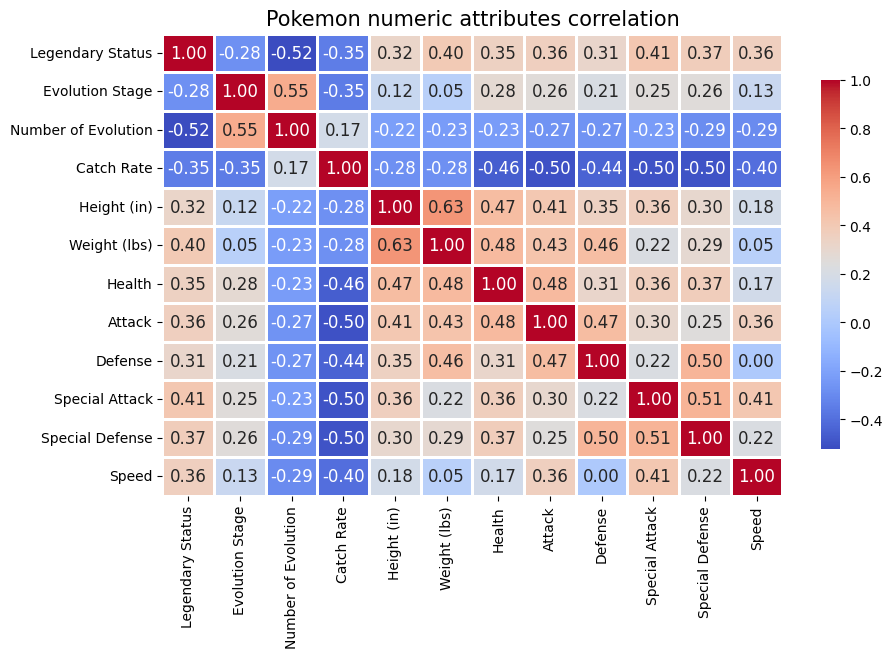

In [4]:
plt.figure(figsize=(10, 6))
sns.heatmap(
    pokemonNumber.corr(),
    annot=True,                   # Afficher les valeurs
    cmap="coolwarm",              # Palette de couleurs alternative plus lisible
    annot_kws={"size": 12},       # Augmente la taille des annotations
    fmt=".2f",                    # Format des nombres (2 décimales)
    linewidths=1,                 # Ajoute des lignes entre les cellules
    cbar_kws={"shrink": 0.8}      # Ajuste la taille de la barre de couleur
)
plt.title("Pokemon numeric attributes correlation", size = 15)

### Loading processed data

In [5]:
# X_train is a SMOTE object
# y_train is a SMOTE object
# X_test not a SMOTE object, but cat values has been converted into numeric vectors
# y_test is inchanged
X_train, y_train, X_test, y_test, preprocessor = prepareDataForMlp(pokemon)
X_train_df = encodedDataToDataFrame(preprocessor, X_train)
X_test_df = encodedDataToDataFrame(preprocessor, X_test)

### Training and optimisation of the model

In [ ]:
mlp = MlpPokemon(X_train, y_train, X_test, y_test, preprocessor)
results = mlp.skorchOptimise(cv=5)
best_params = results['best_params']
print("Meilleurs paramètres:", best_params)
best_model = results['best_mlp_model']

Starting the oprimisation (GridSearchCV with 5 folds)...
Fitting 5 folds for each of 288 candidates, totalling 1440 fits
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6890       0.8543        0.6720  0.3262
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6852       0.7087        0.6338  0.3174
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6658       0.8583        0.6066  0.2910
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.6970       0.5000        0.6852  0.3614
      2        0.5878       0.8740        0.4684  0.3079
      2        0.5668       0.9094        0.4738  0.3131
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -

In [ ]:
mlp2 = MlpPokemon(X_train, y_train, X_test, y_test, preprocessor)
optimisationOutput = mlp2.optimizeHyperparameters(X_train, y_train, X_test, y_test, preprocessor)

### Model evaluation

- Model parameters

In [ ]:
displayParameters(optimisationOutput["bestParams"])

ImportError: cannot import name 'displayParameters' from 'MLP_utils' (/home/edmond/Documents/PytorchProjects/MLP/MLP_pytorch/MLP_utils.py)

- Model performances

=== Cross validation results===
Accuracy: 0.9943 ± 0.0033
Precision: 0.9899 ± 0.0078
Recall: 0.9988 ± 0.0021
F1: 0.9943 ± 0.0033


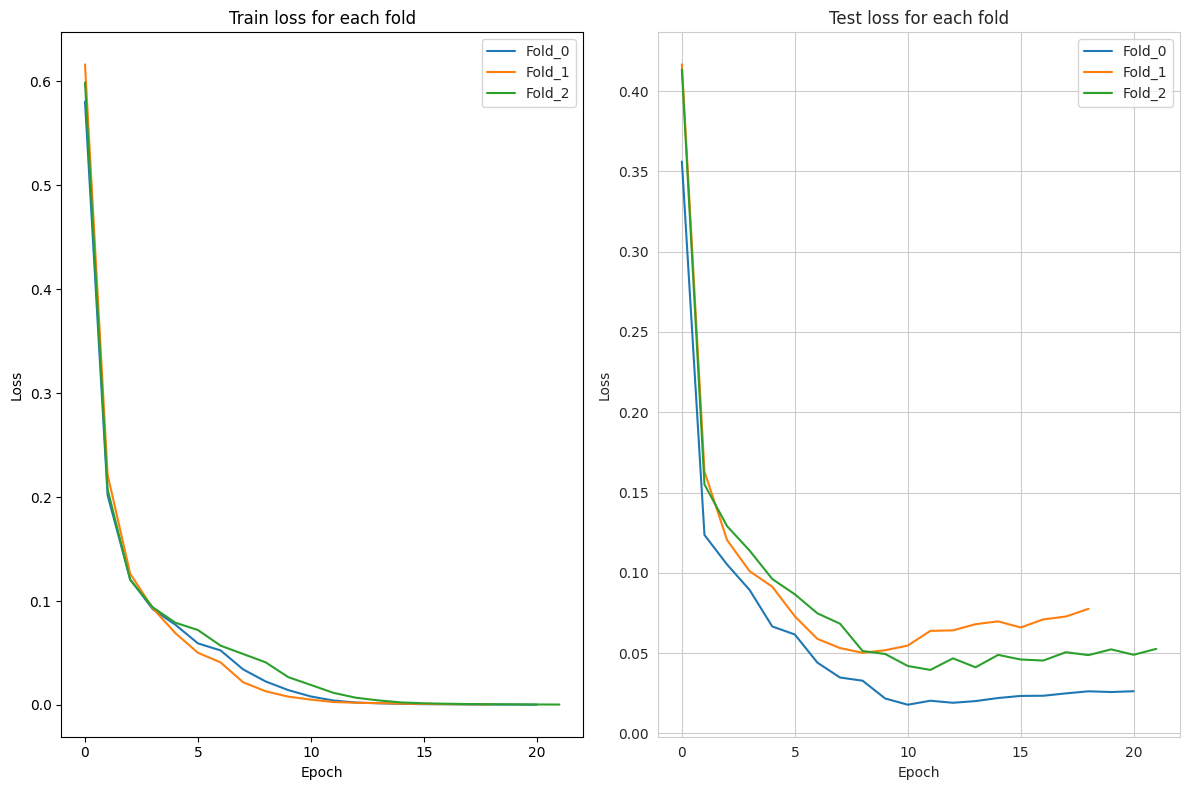

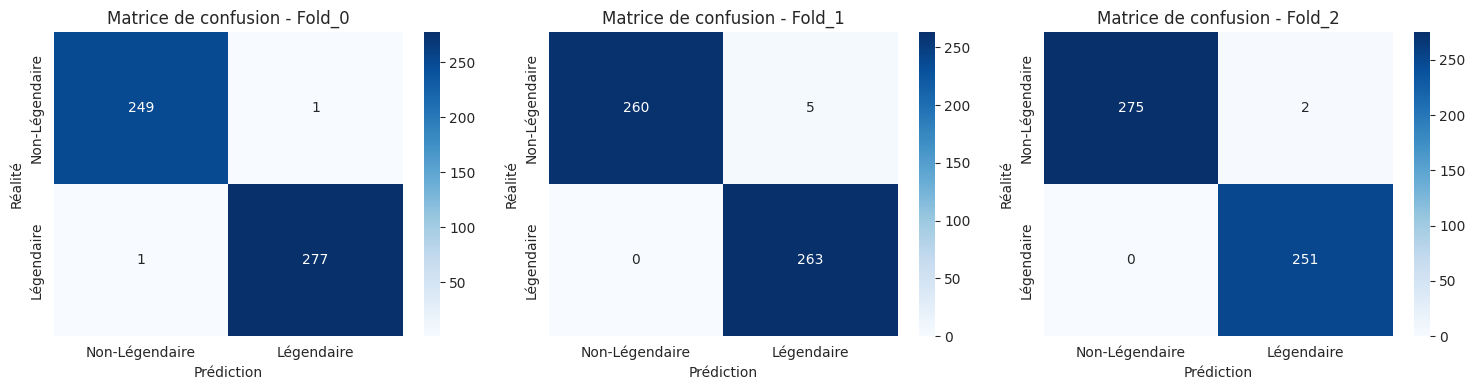

<Figure size 1000x600 with 0 Axes>

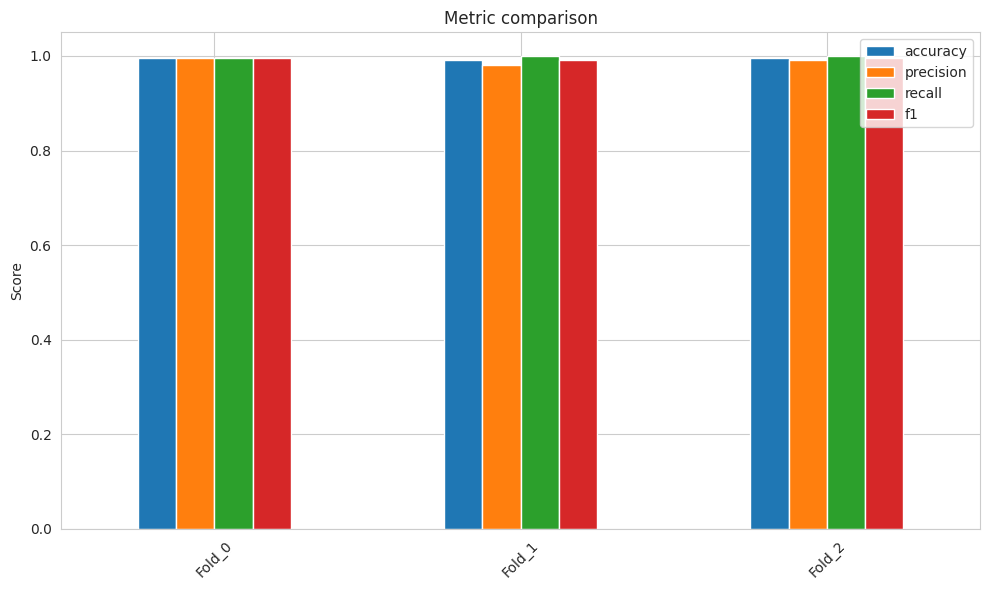

Seuil moyen: 0.7667 ± 0.1179


In [ ]:
cvResults = optimisationOutput["bestResults"]["cvResults"]
completeCvAnalysis(cvResults)

### Test the model on unknown data

- Load the best model

In [ ]:
from torch import optim

# bestParams = optimisationOutput["bestParams"]
bestParams =  {'hiddenDim': 64, 'learningRate': 0.001, 'batchSize': 32, 'numEpochs': 50, 'nbHiddenLayers': 2}


mlp = MlpPokemon(X_train, y_train, X_test, y_test, preprocessor, hiddenDim= bestParams["hiddenDim"], batchSize= bestParams["batchSize"], numEpoch= bestParams["numEpochs"], nbHiddenLayer = bestParams["nbHiddenLayers"])

# Load the saved state_dict into the model
mlp.model.load_state_dict(torch.load("models/best_model.pth"))

# Ensure the model is in evaluation mode
mlp.model.eval()

# Recreate the optimizer with the model's parameters
mlp.optimiser = optim.Adam(mlp.model.parameters(), lr = bestParams['learningRate'])

- Prediction

In [ ]:
testLoss, yProbaPredict = mlp.predict()
print(f"The total loss on test data is {testLoss:4f}.")

The total loss on test data is 0.164395.


- Confusion matrix

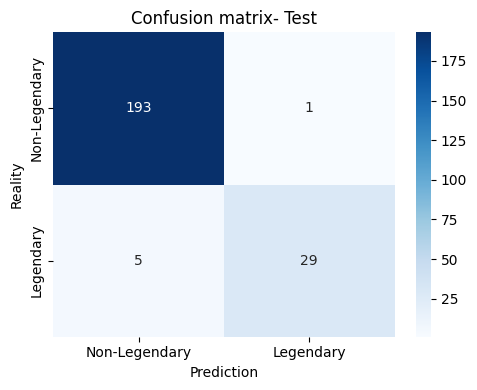

In [ ]:
bestThreshold = getBestThresholdsForF1(y_test, yProbaPredict)
yPredClass = mlp.getPredictionClass(bestThreshold)
confusionMatrix = confusion_matrix(y_test, yPredClass)
plotConfusionMatrices({"Test" : {"confusion": confusionMatrix}})

In [ ]:
dummyCvResults = getPerformanceStatistics(y_test, yPredClass)
dummyCvResults = {"0": dummyCvResults}
analyseCvOutput(dummyCvResults)

=== Cross validation results===
Accuracy: 0.9737 ± nan
Precision: 0.9667 ± nan
Recall: 0.8529 ± nan
F1: 0.9062 ± nan


,accuracy,precision,recall,f1
0,0.973684,0.966667,0.852941,0.90625


- Thresholds analysis

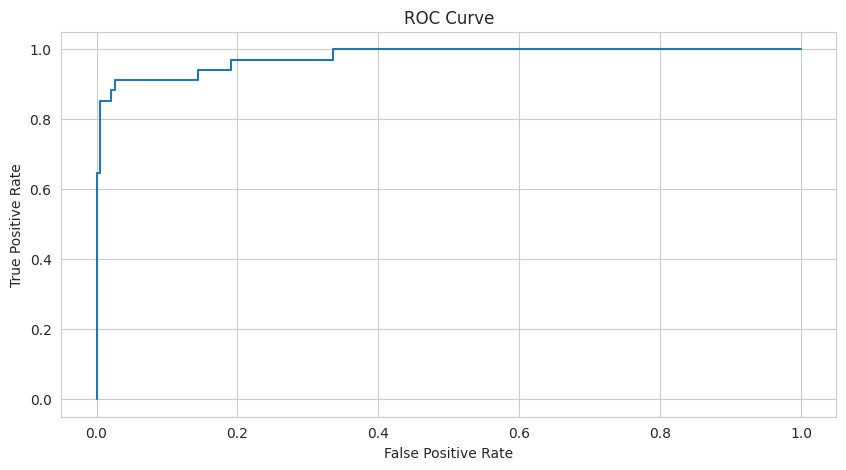

,False positive rate,True positive rate,thresholds
0,0.000000,0.000000,inf
1,0.000000,0.264706,1.000000e+00
2,0.000000,0.294118,9.999994e-01
3,0.000000,0.352941,9.999983e-01
4,0.000000,0.647059,9.988335e-01
5,0.005155,0.647059,9.973562e-01
6,0.005155,0.852941,8.515764e-01
7,0.020619,0.852941,7.868756e-01
8,0.020619,0.882353,4.822507e-01
9,0.025773,0.882353,3.495858e-01


In [ ]:
rocCurve(y_test, yProbaPredict)

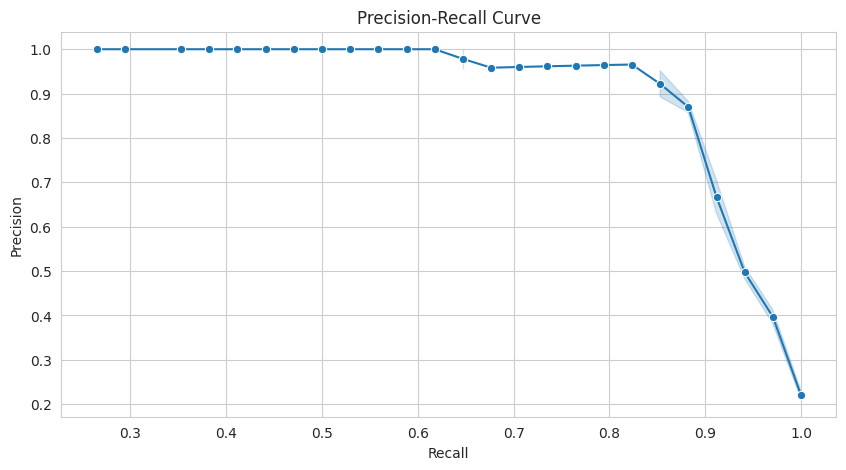

,Precision,Recall,thresholds
0,0.149123,1.000000,9.503711e-11
1,0.149780,1.000000,1.950455e-10
2,0.150442,1.000000,7.349971e-10
3,0.151111,1.000000,2.426197e-09
4,0.151786,1.000000,3.113172e-09
...,...,...,...
212,1.000000,0.411765,9.999970e-01
213,1.000000,0.382353,9.999973e-01
214,1.000000,0.352941,9.999983e-01
215,1.000000,0.294118,9.999994e-01


In [ ]:
precisionRecallCurve(y_test, yProbaPredict)

### Processed data visualisation

- Numeric features

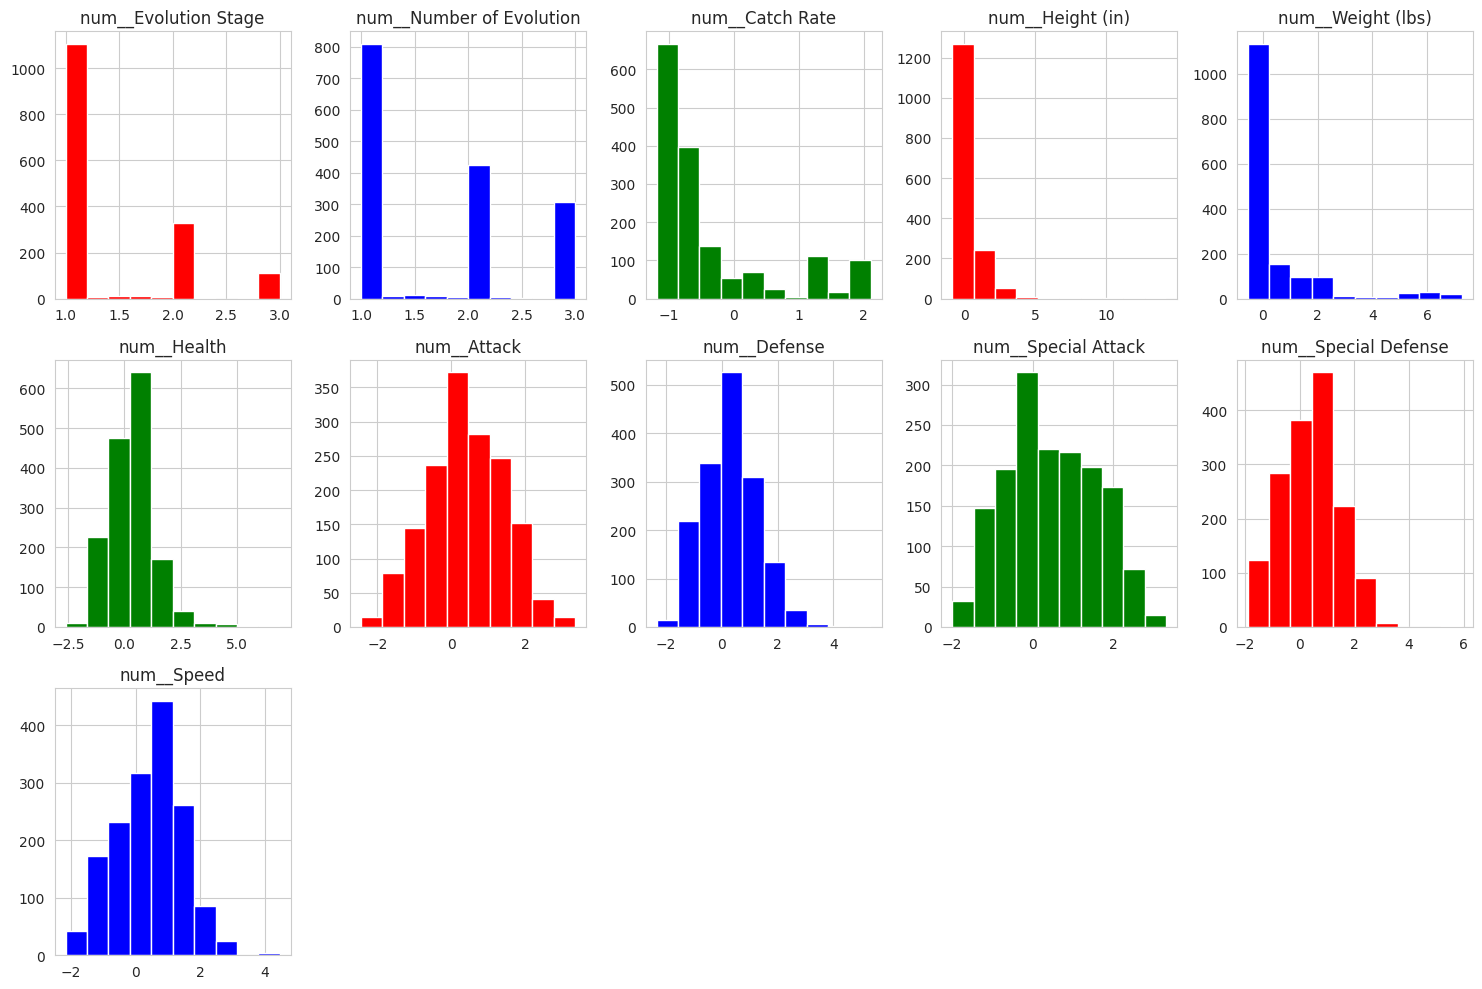

In [ ]:
numDataDistribution(X_train_df, nbPlot= 11)

- Categorical features

/home/edmond/Documents/PytorchProjects/MLP/MLP_pytorch/MLP_utils.py:174: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(catColMinimal, rotation=90)
/home/edmond/Documents/PytorchProjects/MLP/MLP_pytorch/MLP_utils.py:174: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(catColMinimal, rotation=90)
/home/edmond/Documents/PytorchProjects/MLP/MLP_pytorch/MLP_utils.py:174: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(catColMinimal, rotation=90)
/home/edmond/Documents/PytorchProjects/MLP/MLP_pytorch/MLP_utils.py:174: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(catColMinimal, rotation=90)


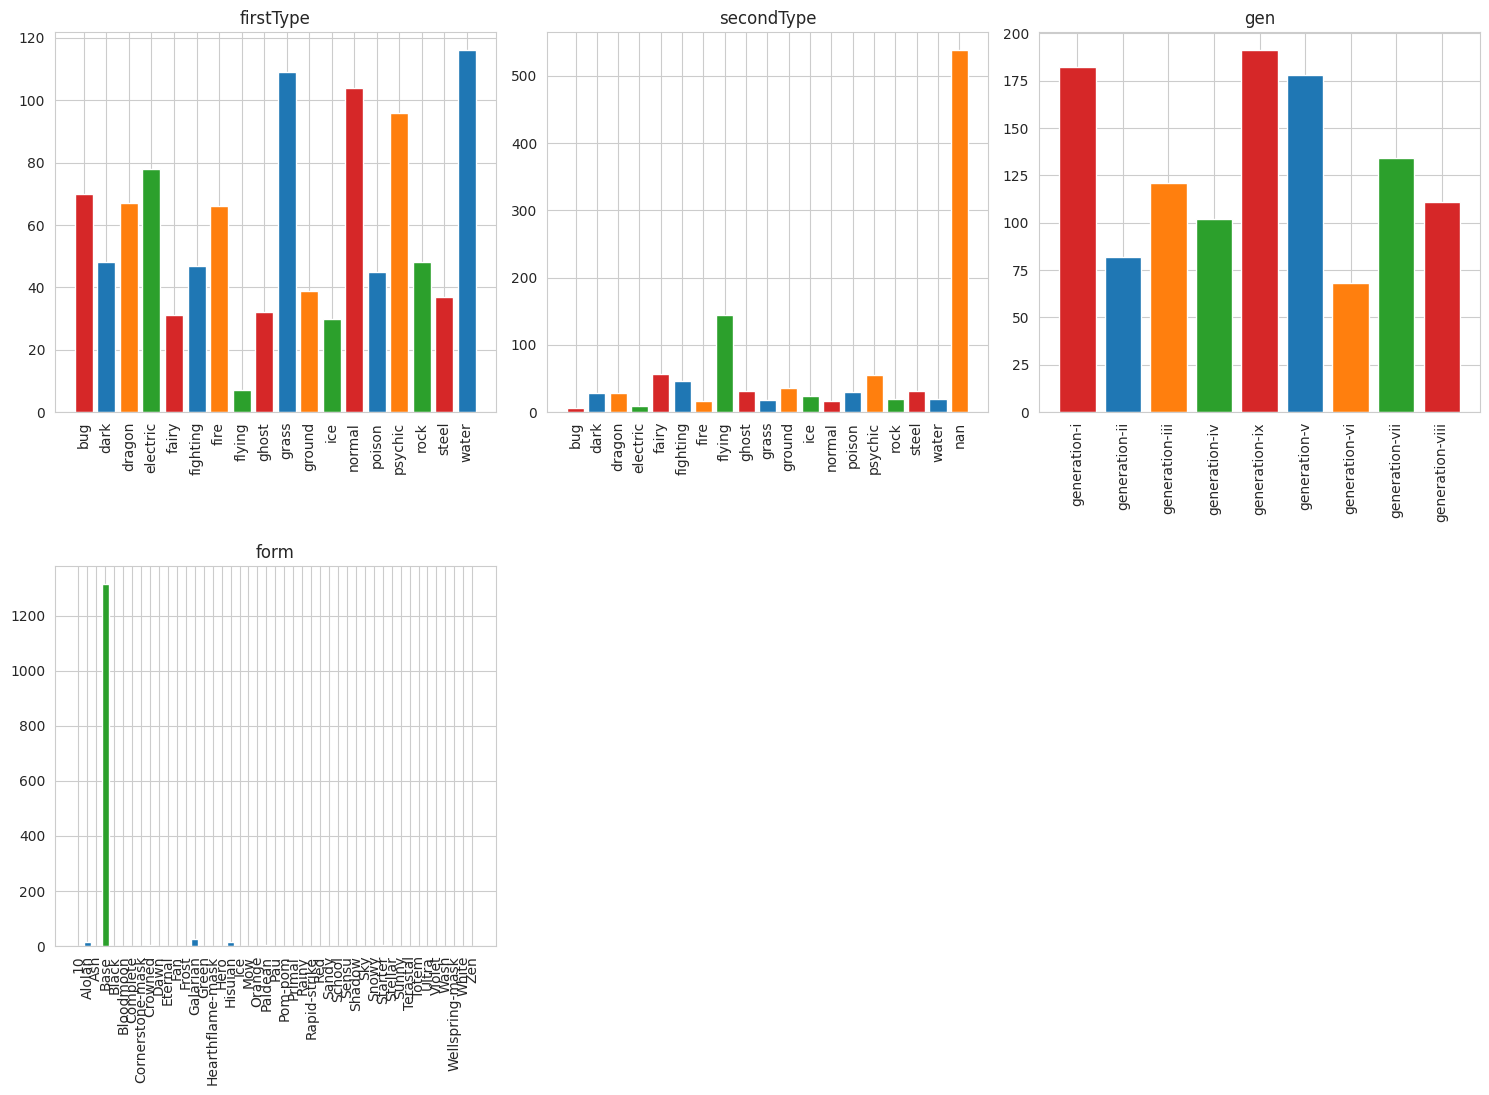

In [ ]:
multiplePlot(X_train_df)